In [ ]:
!kaggle datasets download -d threnjen/2019-airline-delays-and-cancellations

Dataset URL: https://www.kaggle.com/datasets/threnjen/2019-airline-delays-and-cancellations
License(s): U.S. Government Works
100% 751M/754M [00:10<00:00, 71.9MB/s]
100% 754M/754M [00:10<00:00, 74.6MB/s]


In [ ]:
!mkdir /content/dataset

In [ ]:
!unzip /content/2019-airline-delays-and-cancellations.zip -d /content/dataset

Archive:  /content/2019-airline-delays-and-cancellations.zip
  inflating: /content/dataset/full_data_flightdelay.csv  
  inflating: /content/dataset/raw_data/AIRPORT_COORDINATES.csv  
  inflating: /content/dataset/raw_data/B43_AIRCRAFT_INVENTORY.csv  
  inflating: /content/dataset/raw_data/CARRIER_DECODE.csv  
  inflating: /content/dataset/raw_data/GHCND_documentation.pdf  
  inflating: /content/dataset/raw_data/ONTIME_REPORTING_01.csv  
  inflating: /content/dataset/raw_data/ONTIME_REPORTING_02.csv  
  inflating: /content/dataset/raw_data/ONTIME_REPORTING_03.csv  
  inflating: /content/dataset/raw_data/ONTIME_REPORTING_04.csv  
  inflating: /content/dataset/raw_data/ONTIME_REPORTING_05.csv  
  inflating: /content/dataset/raw_data/ONTIME_REPORTING_06.csv  
  inflating: /content/dataset/raw_data/ONTIME_REPORTING_07.csv  
  inflating: /content/dataset/raw_data/ONTIME_REPORTING_08.csv  
  inflating: /content/dataset/raw_data/ONTIME_REPORTING_09.csv  
  inflating: /content/dataset/raw_data

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840625 sha256=c6da9228f7faec0d7c44bc3f81c9f5857bb18013bc70762c060c4acb698598fd
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark


## Libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import time
import pyspark.pandas as ps
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [ ]:
spark = SparkSession.builder.appName("ET2").getOrCreate()

In [ ]:
df = ps.read_csv("/content/dataset/full_data_flightdelay.csv")

In [ ]:
df.shape

(6489062, 26)

dataset has close to 65 lakh rows

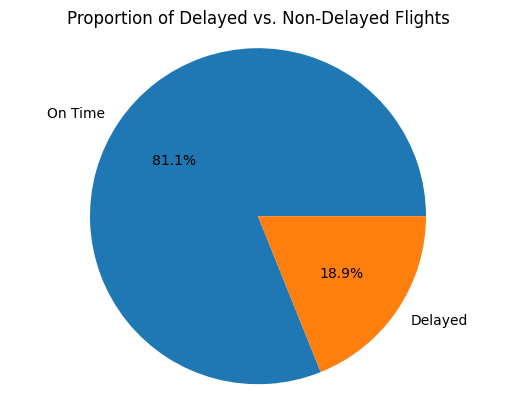

In [ ]:
plt.pie(df['DEP_DEL15'].value_counts().to_numpy(), labels=['On Time', 'Delayed'], autopct='%1.1f%%')

plt.title('Proportion of Delayed vs. Non-Delayed Flights')
plt.axis('equal')

plt.show()

In [ ]:
df.head()

,MONTH,DAY_OF_WEEK,DEP_DEL15,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,FLT_ATTENDANTS_PER_PASS,GROUND_SERV_PER_PASS,PLANE_AGE,DEPARTING_AIRPORT,LATITUDE,LONGITUDE,PREVIOUS_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND
0,10,1,0,1900-1959,3,4,72,158,Delta Air Lines Inc.,33584,86312,21030,4365661,12460183,0.000144,0.000149,21,Atlanta Municipal,33.641,-84.427,El Paso International,0.00,0.0,0.0,77.0,3.13
1,3,2,1,1500-1559,3,4,28,191,Delta Air Lines Inc.,9887,84142,3919,1065782,12460183,0.000144,0.000149,1,Salt Lake City International,40.784,-111.967,Phoenix Sky Harbor International,0.00,0.0,0.0,52.0,7.83
2,5,5,0,0900-0959,2,2,14,100,JetBlue Airways,10452,24886,229,1297685,3190369,0.000160,0.000127,12,Philadelphia International,39.868,-75.249,Logan International,0.01,0.0,0.0,82.0,9.62
3,6,1,0,1300-1359,4,3,16,230,Frontier Airlines Inc.,10055,11337,474,1297685,1857122,0.000116,0.000007,4,Philadelphia International,39.868,-75.249,Memphis International,0.00,0.0,0.0,73.0,10.51
4,12,7,0,0600-0659,6,1,16,76,SkyWest Airlines Inc.,4332,70473,257,477995,3472966,0.000034,0.000099,5,Kansas City International,39.298,-94.714,NONE,0.00,0.0,0.0,51.0,8.95


In [ ]:
df.info()

<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 6489062 entries, 0 to 6489061
Data columns (total 26 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   MONTH                          6489062 non-null  int32  
 1   DAY_OF_WEEK                    6489062 non-null  int32  
 2   DEP_DEL15                      6489062 non-null  int32  
 3   DEP_TIME_BLK                   6489062 non-null  object 
 4   DISTANCE_GROUP                 6489062 non-null  int32  
 5   SEGMENT_NUMBER                 6489062 non-null  int32  
 6   CONCURRENT_FLIGHTS             6489062 non-null  int32  
 7   NUMBER_OF_SEATS                6489062 non-null  int32  
 8   CARRIER_NAME                   6489062 non-null  object 
 9   AIRPORT_FLIGHTS_MONTH          6489062 non-null  int32  
 10  AIRLINE_FLIGHTS_MONTH          6489062 non-null  int32  
 11  AIRLINE_AIRPORT_FLIGHTS_MONTH  6489062 non-null  int32  
 12  AVG_MONTHLY

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
MONTH,6489062.0,6.607062e+00,3.396853e+00,1.000000,4.000000e+00,7.000000e+00,1.000000e+01,1.200000e+01
DAY_OF_WEEK,6489062.0,3.935598e+00,1.995200e+00,1.000000,2.000000e+00,4.000000e+00,6.000000e+00,7.000000e+00
DEP_DEL15,6489062.0,1.891441e-01,3.916231e-01,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
DISTANCE_GROUP,6489062.0,3.821102e+00,2.382233e+00,1.000000,2.000000e+00,3.000000e+00,5.000000e+00,1.100000e+01
SEGMENT_NUMBER,6489062.0,3.046890e+00,1.757864e+00,1.000000,2.000000e+00,3.000000e+00,4.000000e+00,1.500000e+01
CONCURRENT_FLIGHTS,6489062.0,2.783675e+01,2.151060e+01,1.000000,1.100000e+01,2.300000e+01,3.900000e+01,1.090000e+02
NUMBER_OF_SEATS,6489062.0,1.337397e+02,4.645213e+01,44.000000,9.000000e+01,1.430000e+02,1.720000e+02,3.370000e+02
AIRPORT_FLIGHTS_MONTH,6489062.0,1.268458e+04,8.839796e+03,1100.000000,5.345000e+03,1.156200e+04,1.761500e+04,3.525600e+04
AIRLINE_FLIGHTS_MONTH,6489062.0,6.296058e+04,3.438223e+04,5582.000000,2.503400e+04,7.087800e+04,8.631200e+04,1.177280e+05
AIRLINE_AIRPORT_FLIGHTS_MONTH,6489062.0,3.459251e+03,4.251139e+03,1.000000,6.540000e+02,2.251000e+03,4.806000e+03,2.183700e+04


## Duplicates

In [ ]:
df.duplicated().sum()

28473

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df=df.reset_index(drop=True)

We find the count of duplicated row entries

Duplicated entries could cause ml algorithms to give them more importance and skew results so we drop them and reset index

## Missing values


In [ ]:
df.isnull().sum()

MONTH                            0
DAY_OF_WEEK                      0
DEP_DEL15                        0
DEP_TIME_BLK                     0
DISTANCE_GROUP                   0
SEGMENT_NUMBER                   0
CONCURRENT_FLIGHTS               0
NUMBER_OF_SEATS                  0
CARRIER_NAME                     0
AIRPORT_FLIGHTS_MONTH            0
AIRLINE_FLIGHTS_MONTH            0
AIRLINE_AIRPORT_FLIGHTS_MONTH    0
AVG_MONTHLY_PASS_AIRPORT         0
AVG_MONTHLY_PASS_AIRLINE         0
FLT_ATTENDANTS_PER_PASS          0
GROUND_SERV_PER_PASS             0
PLANE_AGE                        0
DEPARTING_AIRPORT                0
LATITUDE                         0
LONGITUDE                        0
PREVIOUS_AIRPORT                 0
PRCP                             0
SNOW                             0
SNWD                             0
TMAX                             0
AWND                             0
dtype: int64

Converting to Spark dataframe

In [ ]:
df = df.to_spark()

In [ ]:
df.show(1)

+-----+-----------+---------+------------+--------------+--------------+------------------+---------------+--------------------+---------------------+---------------------+-----------------------------+------------------------+------------------------+-----------------------+--------------------+---------+--------------------+--------+---------+----------------+----+----+----+----+----+
|MONTH|DAY_OF_WEEK|DEP_DEL15|DEP_TIME_BLK|DISTANCE_GROUP|SEGMENT_NUMBER|CONCURRENT_FLIGHTS|NUMBER_OF_SEATS|        CARRIER_NAME|AIRPORT_FLIGHTS_MONTH|AIRLINE_FLIGHTS_MONTH|AIRLINE_AIRPORT_FLIGHTS_MONTH|AVG_MONTHLY_PASS_AIRPORT|AVG_MONTHLY_PASS_AIRLINE|FLT_ATTENDANTS_PER_PASS|GROUND_SERV_PER_PASS|PLANE_AGE|   DEPARTING_AIRPORT|LATITUDE|LONGITUDE|PREVIOUS_AIRPORT|PRCP|SNOW|SNWD|TMAX|AWND|
+-----+-----------+---------+------------+--------------+--------------+------------------+---------------+--------------------+---------------------+---------------------+-----------------------------+------------------

#EDA

In [ ]:
df.count()

6460589

## Departure time by block

In [ ]:
total_count = df.count()

# Calculate the percentage of each DEP_TIME_BLK value
df_percentage = df.groupBy("DEP_TIME_BLK") \
    .agg(F.round((F.count("DEP_TIME_BLK") / total_count * 100),2)\
    .alias("percentage")) \
    .orderBy(F.desc("percentage"))\
    .show()

+------------+----------+
|DEP_TIME_BLK|percentage|
+------------+----------+
|   0800-0859|      6.99|
|   0700-0759|      6.71|
|   0600-0659|      6.64|
|   1700-1759|      6.27|
|   1200-1259|      6.17|
|   1000-1059|      6.16|
|   0900-0959|      6.13|
|   1100-1159|      6.07|
|   1500-1559|      5.95|
|   1400-1459|      5.78|
|   1800-1859|      5.77|
|   1600-1659|      5.67|
|   1900-1959|      5.52|
|   1300-1359|      5.44|
|   2000-2059|      5.25|
|   2100-2159|      3.42|
|   2200-2259|      2.98|
|   0001-0559|      2.29|
|   2300-2359|      0.79|
+------------+----------+



Vast drop in late night/early morning flights

In [ ]:
time_blocks_order = [
    1,   #'Early Morning & Late Night',  # 0001-0559
    2,   #'Morning',                     # 0600-1159
    3,   #'Afternoon',                   # 1200-1659
    4,   #'Evening',                     # 1700-1959
    5,   #'Night'                        # 2000-2359
]

def time_of_day(time_blk):
    dep_time = int(time_blk.split('-')[0])
    if 0 <= dep_time < 600:
        return 1
    elif 600 <= dep_time < 1200:
        return 2
    elif 1200 <= dep_time < 1700:
        return 3
    elif 1700 <= dep_time < 2000:
        return 4
    elif 2000 <= dep_time < 2400:
        return 5
    else:
        return None

In [ ]:
# Register the UDF
time_of_day_udf = F.udf(time_of_day, T.IntegerType())

In [ ]:
# Apply the UDF to create the 'PART_OF_DAY' column
df = df.withColumn("PART_OF_DAY", time_of_day_udf(F.col("DEP_TIME_BLK")))

In [ ]:
# Show the result
df.select("DEP_TIME_BLK", "PART_OF_DAY").show()

+------------+-----------+
|DEP_TIME_BLK|PART_OF_DAY|
+------------+-----------+
|   0001-0559|          1|
|   0001-0559|          1|
|   0001-0559|          1|
|   0001-0559|          1|
|   0001-0559|          1|
|   0001-0559|          1|
|   0001-0559|          1|
|   0001-0559|          1|
|   0001-0559|          1|
|   0001-0559|          1|
|   0001-0559|          1|
|   0001-0559|          1|
|   0001-0559|          1|
|   0001-0559|          1|
|   0001-0559|          1|
|   0001-0559|          1|
|   0001-0559|          1|
|   0001-0559|          1|
|   0001-0559|          1|
|   0001-0559|          1|
+------------+-----------+
only showing top 20 rows



In [ ]:
part_of_day_counts = df.groupBy("PART_OF_DAY").count().orderBy("PART_OF_DAY").collect()

In [ ]:
part_of_day_counts

[Row(PART_OF_DAY=1, count=22870),
 Row(PART_OF_DAY=2, count=387044),
 Row(PART_OF_DAY=3, count=290051),
 Row(PART_OF_DAY=4, count=175651),
 Row(PART_OF_DAY=5, count=124384)]

In [ ]:
labels = ['Early Morning & Late Night','Morning','Afternoon','Evening','Night' ]
sizes = [row[1] for row in part_of_day_counts]

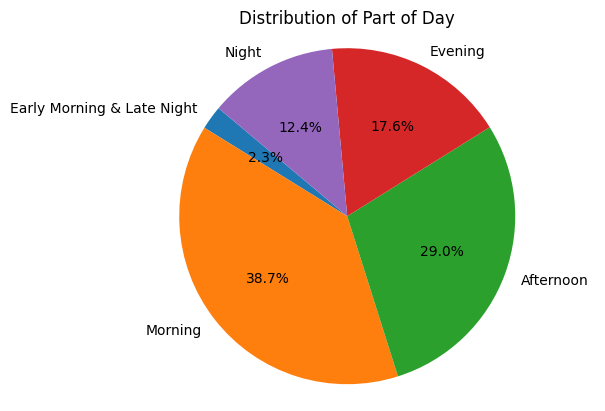

In [ ]:
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Part of Day')
plt.axis('equal')
plt.show()

## Wind Speed

In [ ]:
# Extract the data for each class into Pandas DataFrames
data_class0 = df.filter(df['DEP_DEL15'] == 0).select('AWND').toPandas()
data_class1 = df.filter(df['DEP_DEL15'] == 1).select('AWND').toPandas()


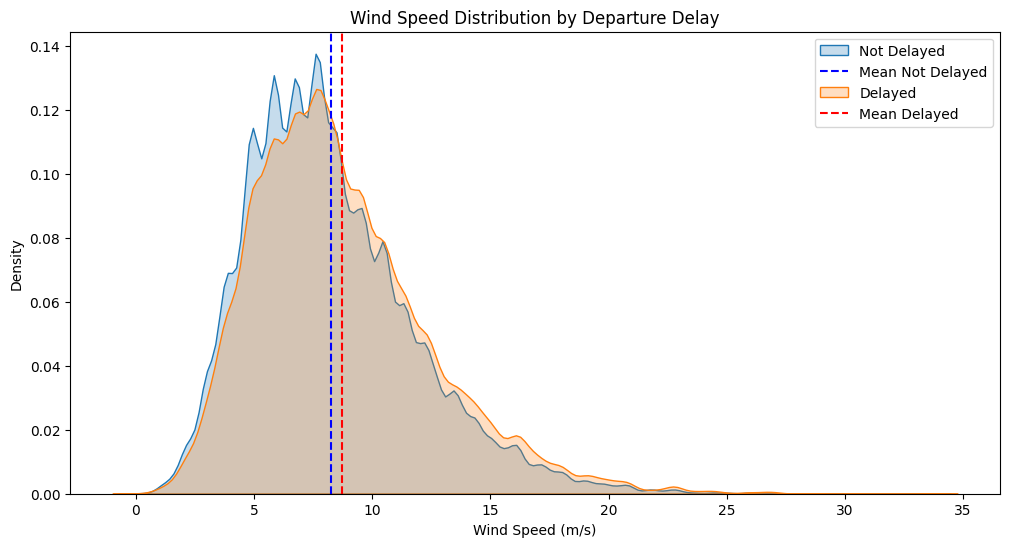

In [ ]:
plt.figure(figsize=(12, 6))

# Plot the KDE for class 0 (DEP_DEL15 == 0)
sns.kdeplot(data_class0['AWND'],label='Not Delayed',fill = True)
plt.axvline(data_class0['AWND'].mean(), color='blue', linestyle='--', label='Mean Not Delayed')

# Plot the KDE for class 1 (DEP_DEL15 == 1)
sns.kdeplot(data_class1['AWND'], label='Delayed',fill = True)
plt.axvline(data_class1['AWND'].mean(), color='red', linestyle='--',label='Mean Delayed')


plt.legend()
plt.title('Wind Speed Distribution by Departure Delay')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Density')
plt.show()

Approximately after the wind speed increases past the mean of non delay the density of flights who have delay is higher.

## Snow

### Inches of snowfall for day (SNOW)

In [ ]:
filtered_df = df.filter(df["SNOW"] > 0)

pandas_df = filtered_df.select("SNOW", "DEP_DEL15").toPandas()

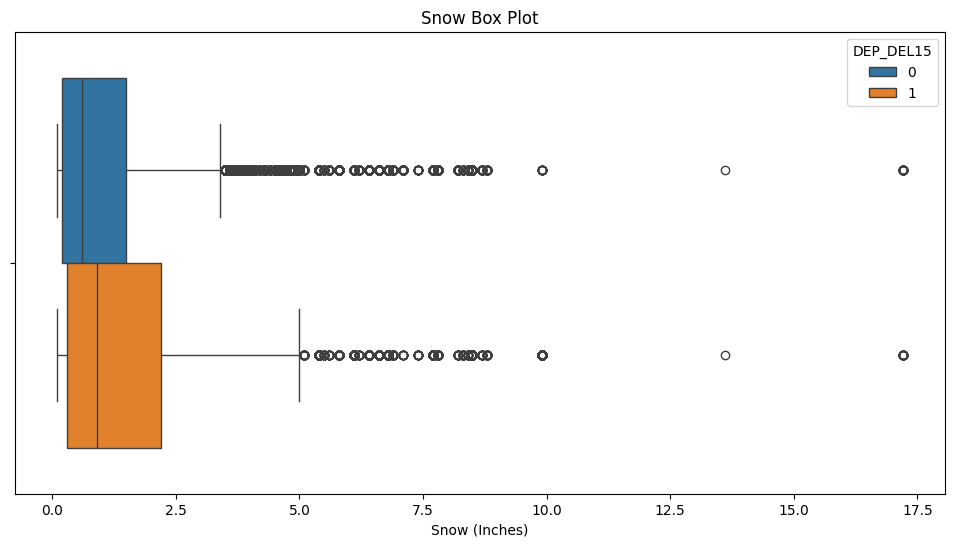

In [ ]:
plt.figure(figsize=(12, 6))
plt.title("Snow Box Plot")
plt.xlabel("Snow (Inches)")

sns.boxplot(data=pandas_df, x="SNOW", hue="DEP_DEL15")

plt.show()

We can notice that there is a wider spread of snow amounts for delayed flights compared to non-delayed flights. This suggests that there may be a relationship between the amount of snow and whether or not a flight is delayed, with flights experiencing more snow being more likely to be delayed.

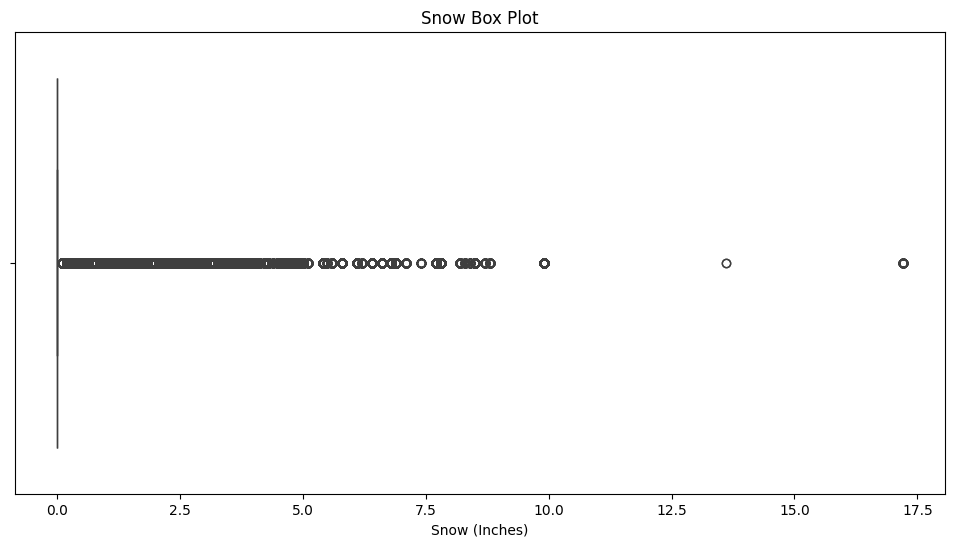

In [ ]:
pandas_df = df.select("SNOW").toPandas()

plt.figure(figsize=(12, 6))
plt.title("Snow Box Plot")
plt.xlabel("Snow (Inches)")

sns.boxplot(data=pandas_df, x="SNOW")

plt.show()

In [ ]:
total_count = df.count()
# Calculate the percentage of each Snow value
df_percentage = df.groupBy("SNOW") \
    .agg(F.round((F.count("SNOW") / total_count * 100),2)\
    .alias("percentage")) \
    .orderBy(F.desc("percentage"))\
    .show()

+----+----------+
|SNOW|percentage|
+----+----------+
| 0.0|      97.5|
| 0.1|      0.43|
| 0.2|      0.25|
| 0.3|      0.18|
| 1.0|      0.15|
| 0.5|      0.12|
| 0.4|      0.12|
| 0.7|       0.1|
| 0.6|      0.09|
| 1.2|      0.08|
| 0.9|      0.08|
| 0.8|      0.07|
| 1.1|      0.06|
| 1.5|      0.06|
| 1.3|      0.05|
| 1.8|      0.05|
| 2.3|      0.04|
| 2.0|      0.04|
| 2.5|      0.03|
| 1.4|      0.03|
+----+----------+
only showing top 20 rows



97.5% data is 0
We can either leave it as data over 0 does provide some information or deal with it

1) Binarization
Binarize the 'SNOW' column: 0 if snow is 0.0, 1 otherwise

In [ ]:
df = df.withColumn('SNOW_binary', F.when(df['SNOW'] == 0.0, 0).otherwise(1))

2) Binning

In [ ]:
df = df.withColumn('SNOW_binned',
                   F.when(df['SNOW'] == 0.0, 'No Snow')
                   .when(df['SNOW'] <= 0.5, 'Light Snow')
                   .when(df['SNOW'] <= 1.5, 'Moderate Snow')
                   .otherwise('Heavy Snow'))

In [ ]:
df.show(1)

+--------------------+-----+-----------+---------+------------+--------------+--------------+------------------+---------------+---------------------+---------------------+-----------------------------+------------------------+------------------------+-----------------------+--------------------+---------+--------------------+--------+---------+----------------+----+----+----+----+----+--------------------+---------------------------+-------------------------+-----------+-----------+-----------+
|        CARRIER_NAME|MONTH|DAY_OF_WEEK|DEP_DEL15|DEP_TIME_BLK|DISTANCE_GROUP|SEGMENT_NUMBER|CONCURRENT_FLIGHTS|NUMBER_OF_SEATS|AIRPORT_FLIGHTS_MONTH|AIRLINE_FLIGHTS_MONTH|AIRLINE_AIRPORT_FLIGHTS_MONTH|AVG_MONTHLY_PASS_AIRPORT|AVG_MONTHLY_PASS_AIRLINE|FLT_ATTENDANTS_PER_PASS|GROUND_SERV_PER_PASS|PLANE_AGE|   DEPARTING_AIRPORT|LATITUDE|LONGITUDE|PREVIOUS_AIRPORT|PRCP|SNOW|SNWD|TMAX|AWND|CARRIER_NAME_Encoded|carrier_flights_interaction|log_airline_flights_month|PART_OF_DAY|SNOW_binary|SNOW_binned

### snow on ground (SNWD)

Inches of snow on ground for day

In [ ]:
df.groupBy("SNWD")\
    .agg(F.round((F.count("SNWD") / total_count * 100),2)\
    .alias("percentage")) \
    .orderBy(F.desc("percentage"))\
    .show()

+----+----------+
|SNWD|percentage|
+----+----------+
| 0.0|     97.34|
| 1.2|      0.85|
| 2.0|      0.52|
| 3.1|      0.33|
| 3.9|      0.28|
| 5.1|      0.24|
| 7.1|      0.12|
| 5.9|       0.1|
| 9.1|      0.06|
| 7.9|      0.05|
| 9.8|      0.02|
|11.0|      0.02|
|18.9|      0.01|
| 1.0|      0.01|
|18.1|      0.01|
|14.2|      0.01|
|13.0|      0.01|
|11.8|      0.01|
|15.0|      0.01|
| 7.0|       0.0|
+----+----------+
only showing top 20 rows



1) Binarization
Binarize the 'SNWD' column: 0 if snow is 0.0, 1 otherwise

In [ ]:
df = df.withColumn('SNWD_binary', F.when(df['SNWD'] == 0.0, 0).otherwise(1))

2) Binning

In [ ]:
df = df.withColumn('SNWD_binned',
                   F.when(df['SNWD'] == 0.0, 'No Snow')
                   .when(df['SNWD'] <= 5.0, 'Low Snow Depth')
                   .when(df['SNWD'] <= 10.0, 'Moderate Snow Depth')
                   .otherwise('High Snow Depth'))

In [ ]:
df.show(1)

+--------------------+-----+-----------+---------+------------+--------------+--------------+------------------+---------------+---------------------+---------------------+-----------------------------+------------------------+------------------------+-----------------------+--------------------+---------+--------------------+--------+---------+----------------+----+----+----+----+----+--------------------+---------------------------+-------------------------+-----------+-----------+-----------+-----------+-----------+
|        CARRIER_NAME|MONTH|DAY_OF_WEEK|DEP_DEL15|DEP_TIME_BLK|DISTANCE_GROUP|SEGMENT_NUMBER|CONCURRENT_FLIGHTS|NUMBER_OF_SEATS|AIRPORT_FLIGHTS_MONTH|AIRLINE_FLIGHTS_MONTH|AIRLINE_AIRPORT_FLIGHTS_MONTH|AVG_MONTHLY_PASS_AIRPORT|AVG_MONTHLY_PASS_AIRLINE|FLT_ATTENDANTS_PER_PASS|GROUND_SERV_PER_PASS|PLANE_AGE|   DEPARTING_AIRPORT|LATITUDE|LONGITUDE|PREVIOUS_AIRPORT|PRCP|SNOW|SNWD|TMAX|AWND|CARRIER_NAME_Encoded|carrier_flights_interaction|log_airline_flights_month|PART_OF_DAY

## Precipitation

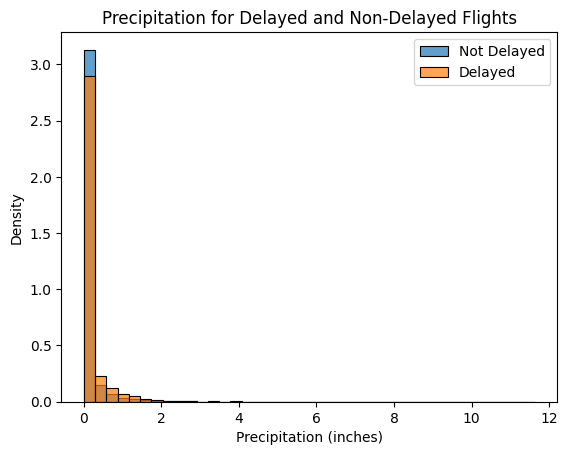

In [ ]:
sns.histplot(data_class0['PRCP'],label='Not Delayed', stat="density", bins=40, alpha=0.7)
sns.histplot(data_class1['PRCP'],label='Delayed', stat="density", bins=40, alpha=0.7)
plt.title('Precipitation for Delayed and Non-Delayed Flights')
plt.xlabel('Precipitation (inches)')
plt.ylabel('Density')
plt.legend()
plt.show()

In [ ]:
df.groupBy("PRCP")\
    .agg(F.round((F.count("PRCP") / total_count * 100),2)\
    .alias("percentage")) \
    .orderBy(F.desc("percentage"))\
    .show()

+----+----------+
|PRCP|percentage|
+----+----------+
| 0.0|     70.18|
|0.01|      3.54|
|0.02|      1.66|
|0.03|      1.47|
|0.05|      1.23|
|0.04|      1.13|
|0.07|      0.87|
|0.06|      0.78|
| 0.1|      0.66|
|0.08|      0.66|
|0.09|      0.64|
|0.12|      0.54|
|0.11|      0.52|
|0.13|      0.49|
|0.14|      0.47|
|0.19|      0.47|
|0.15|      0.44|
|0.16|      0.41|
|0.17|      0.41|
|0.21|      0.34|
+----+----------+
only showing top 20 rows



Data is heavy towards 0 to patterns within we'll look from a log point of view

In [ ]:
# Extract the data for each class into Pandas DataFrames
data_class0 = df.filter(df['DEP_DEL15'] == 0).select('PRCP').toPandas()
data_class1 = df.filter(df['DEP_DEL15'] == 1).select('PRCP').toPandas()


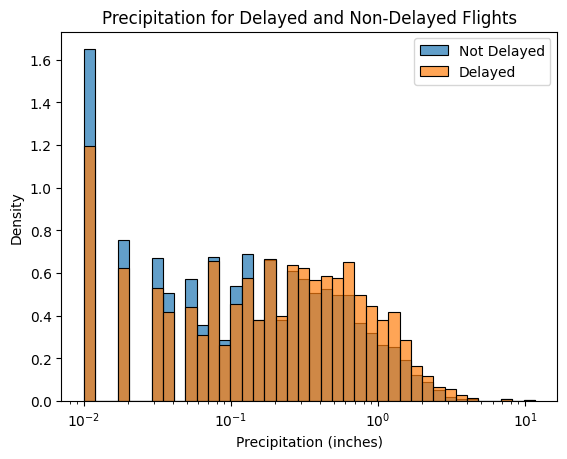

In [ ]:
sns.histplot(data_class0['PRCP'],label='Not Delayed', stat="density", bins=40, alpha=0.7, log_scale = True)
sns.histplot(data_class1['PRCP'],label='Delayed', stat="density", bins=40, alpha=0.7, log_scale = True)
plt.title('Precipitation for Delayed and Non-Delayed Flights')
plt.xlabel('Precipitation (inches)')
plt.ylabel('Density')
plt.legend()
plt.show()

As precipitation gets higher, delay density goes higher as well

## Temperature

In [ ]:
data = df.select('DEP_DEL15','TMAX','MONTH').toPandas()

<Axes: title={'center': 'Max Tempartue Across Months'}, xlabel='Month', ylabel='Max Temparture (F)'>

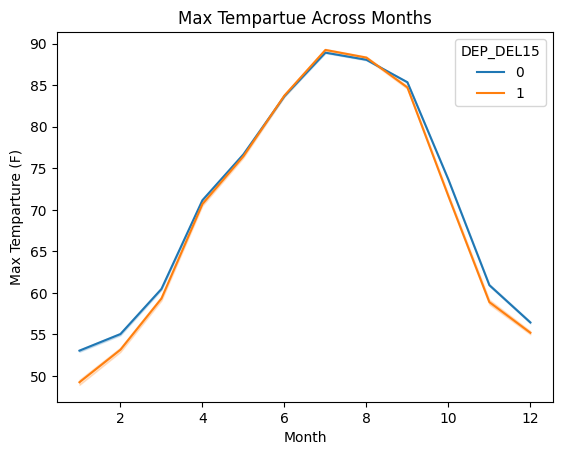

In [ ]:
plt.title("Max Tempartue Across Months")
plt.xlabel("Month")
plt.ylabel("Max Temparture (F)")
sns.lineplot(x = data['MONTH'], y = data['TMAX'], hue = data['DEP_DEL15'])

Delays surpass during middle of the year, although temperature alone may not be causing the delays but could possibly affect other weather parameters

## Day of week / Month

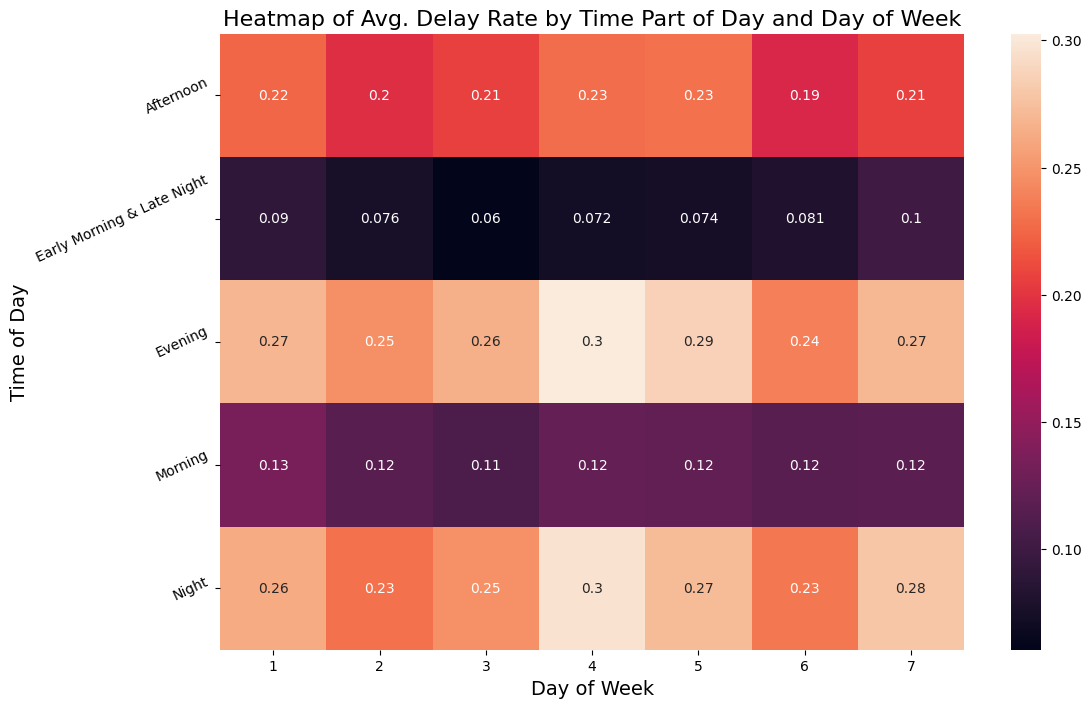

In [ ]:
names = ['Early Morning & Late Night','Morning','Afternoon','Evening','Night']

mapping_expr = F.when(F.col("PART_OF_DAY") == 1, names[0]) \
                .when(F.col("PART_OF_DAY") == 2, names[1]) \
                .when(F.col("PART_OF_DAY") == 3, names[2]) \
                .when(F.col("PART_OF_DAY") == 4, names[3]) \
                .when(F.col("PART_OF_DAY") == 5, names[4])


heatmap_data = df.withColumn("PART_OF_DAY_NAME", mapping_expr)\
    .groupBy("PART_OF_DAY_NAME", "DAY_OF_WEEK") \
    .agg(F.mean("DEP_DEL15")\
    .alias("avg_delay_rate"))\
    .toPandas()\
    .pivot(index='PART_OF_DAY_NAME', columns='DAY_OF_WEEK', values='avg_delay_rate')

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True)

# Adding titles and labels
plt.title('Heatmap of Avg. Delay Rate by Time Part of Day and Day of Week', fontsize=16)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Time of Day', fontsize=14)
plt.yticks(rotation=25)
plt.show()


Time of day highly affects the change of delays

## Plane Age

In [ ]:
# Extract the data for each class into Pandas DataFrames
data_class0 = df.filter(df['DEP_DEL15'] == 0).select('PLANE_AGE').toPandas()
data_class1 = df.filter(df['DEP_DEL15'] == 1).select('PLANE_AGE').toPandas()


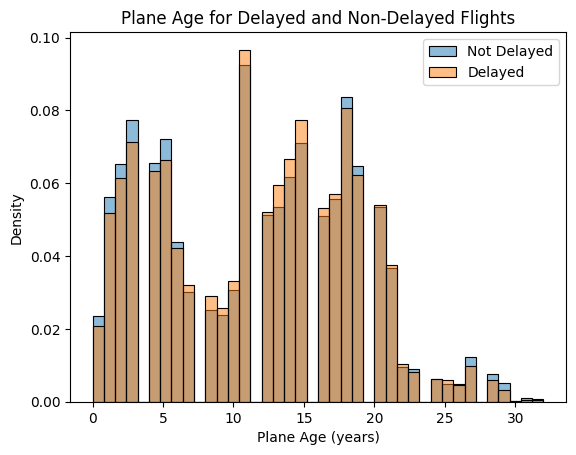

In [ ]:
sns.histplot(data_class0['PLANE_AGE'], label='Not Delayed', stat="density", bins=40, alpha=0.5)
sns.histplot(data_class1['PLANE_AGE'], label='Delayed', stat="density", bins=40, alpha=0.5)

plt.title('Plane Age for Delayed and Non-Delayed Flights')
plt.xlabel('Plane Age (years)')
plt.ylabel('Density')
plt.legend()
plt.show()

Pattern of mid age planes having higher chance of getting planes delayed

## NUMBER OF SEATS

In [ ]:
# Extract the data for each class into Pandas DataFrames
data_class0 = df.filter(df['DEP_DEL15'] == 0).select('NUMBER_OF_SEATS').toPandas()
data_class1 = df.filter(df['DEP_DEL15'] == 1).select('NUMBER_OF_SEATS').toPandas()


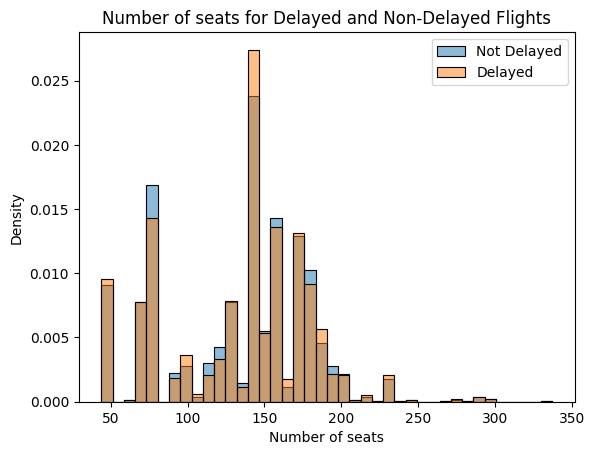

In [ ]:
sns.histplot(data_class0['NUMBER_OF_SEATS'], label='Not Delayed', stat="density", bins=40, alpha=0.5)
sns.histplot(data_class1['NUMBER_OF_SEATS'], label='Delayed', stat="density", bins=40, alpha=0.5)

plt.title('Number of seats for Delayed and Non-Delayed Flights')
plt.xlabel('Number of seats')
plt.ylabel('Density')
plt.legend()
plt.show()

Number of seats may not provide much detail in terms of plane delayment

## DISTANCE_GROUP

DISTANCE_GROUP refers to a classification that categorizes flights based on the distance they are going to cover. In aviation, flights are often grouped into categories based on the length of the route to standardize reporting, analysis, and operational planning


This grouping helps airlines, regulators, and analysts to quickly understand and manage flights of different lengths without having to refer to specific distances every time. For a departing aircraft, the DISTANCE_GROUP would indicate how far that particular flight is expected to travel based on its departure and destination points.

In [ ]:
df.groupBy("DISTANCE_GROUP") \
    .agg(F.mean("DEP_DEL15").alias("avg_delay_rate"))\
    .show()


+--------------+-------------------+
|DISTANCE_GROUP|     avg_delay_rate|
+--------------+-------------------+
|             1|0.17368043898656144|
|             6|0.19367582327599173|
|             3| 0.1892604968497427|
|             5| 0.2054484109397115|
|             9|0.19888757795381762|
|             4|0.19523986067884913|
|             8| 0.2036638138900856|
|             7|0.20231698196825748|
|            10|0.18869074021622373|
|            11|0.19141960912877293|
|             2|0.18197322711541145|
+--------------+-------------------+



In [ ]:
df_grouped = df.groupBy("DISTANCE_GROUP") \
    .agg(F.mean("DEP_DEL15").alias("avg_delay_rate")) \
    .toPandas()

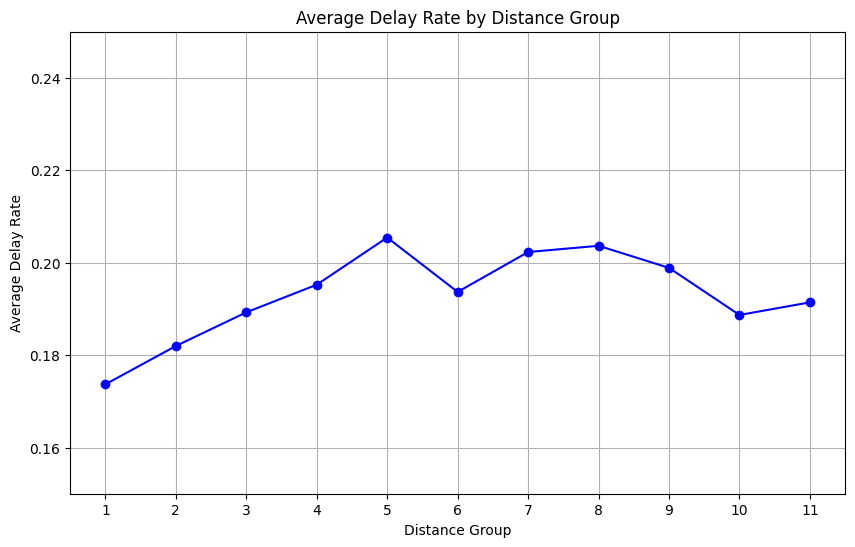

In [ ]:
df_grouped = df_grouped.sort_values(by="DISTANCE_GROUP")

plt.figure(figsize=(10, 6))
plt.plot(df_grouped["DISTANCE_GROUP"], df_grouped["avg_delay_rate"], marker='o', color='b', linestyle='-')
plt.xlabel("Distance Group")
plt.ylabel("Average Delay Rate")
plt.title("Average Delay Rate by Distance Group")
plt.xticks(df_grouped["DISTANCE_GROUP"])
plt.ylim(0.15,0.25)
plt.grid(True)
plt.show()


There is slight increase in delays as distance increases

## SEGMENT_NUMBER

SEGMENT_NUMBER: Represents a flight or leg of a journey

This is common in aviation to track multiple flights that an aircraft completes in a single day

In [ ]:
df_grouped = df.groupBy("SEGMENT_NUMBER") \
    .agg(F.mean("DEP_DEL15").alias("avg_delay_rate"))\
    .toPandas()


A higher avg_delay_rate indicates a higher proportion of delays for that segment.

A lower avg_delay_rate means that fewer instances in that segment were delayed by more than 15 minutes.

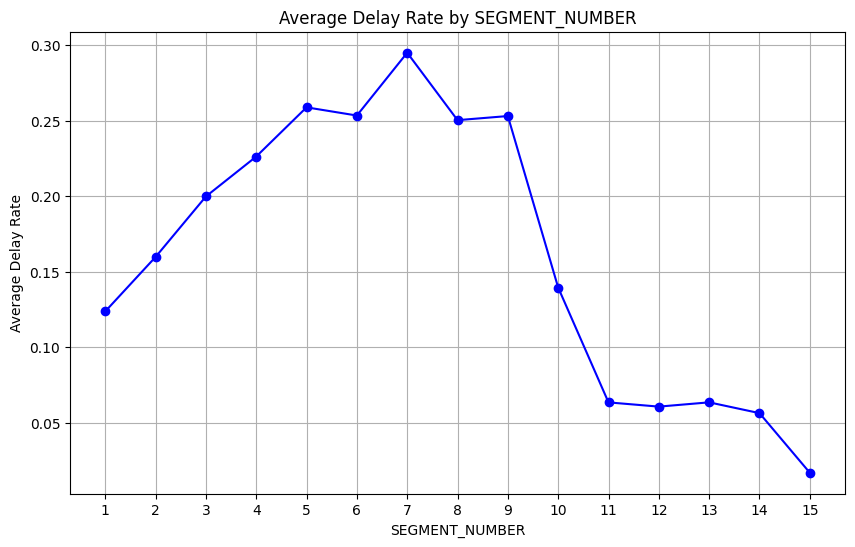

In [ ]:
df_grouped = df.groupBy("SEGMENT_NUMBER") \
    .agg(F.mean("DEP_DEL15").alias("avg_delay_rate"))\
    .toPandas()

df_grouped = df_grouped.sort_values(by="SEGMENT_NUMBER")

plt.figure(figsize=(10, 6))
plt.plot(df_grouped["SEGMENT_NUMBER"], df_grouped["avg_delay_rate"], marker='o', color='b', linestyle='-')
plt.xlabel("SEGMENT_NUMBER")
plt.ylabel("Average Delay Rate")
plt.title("Average Delay Rate by SEGMENT_NUMBER")
plt.xticks(df_grouped["SEGMENT_NUMBER"])
plt.grid(True)
plt.show()


Huge dip in delays as number of flights for the day increases

## CONCURRENT_FLIGHTS
Concurrent flights leaving from the airport in the same departure block

In [ ]:
# Extract the data for each class into Pandas DataFrames
data_class0 = df.filter(df['DEP_DEL15'] == 0).select('CONCURRENT_FLIGHTS').toPandas()
data_class1 = df.filter(df['DEP_DEL15'] == 1).select('CONCURRENT_FLIGHTS').toPandas()



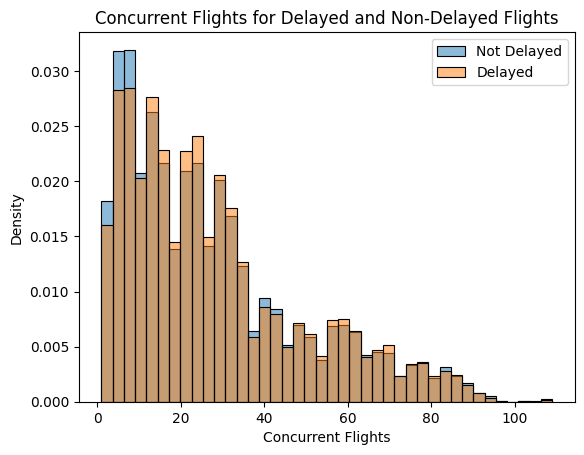

In [ ]:
sns.histplot(data_class0['CONCURRENT_FLIGHTS'], label='Not Delayed', stat="density", bins=40, alpha=0.5)
sns.histplot(data_class1['CONCURRENT_FLIGHTS'], label='Delayed', stat="density", bins=40, alpha=0.5)

plt.title('Concurrent Flights for Delayed and Non-Delayed Flights')
plt.xlabel('Concurrent Flights')
plt.ylabel('Density')
plt.legend()
plt.show()

There is an increasing and decreasing density of delayment as concurrent flights increase

## GROUND_SERV_PER_PASS
Ground service employees (service desk) per passenger for airline

In [ ]:
# Extract the data for each class into Pandas DataFrames
data_class0 = df.filter(df['DEP_DEL15'] == 0).select('GROUND_SERV_PER_PASS').toPandas()
data_class1 = df.filter(df['DEP_DEL15'] == 1).select('GROUND_SERV_PER_PASS').toPandas()


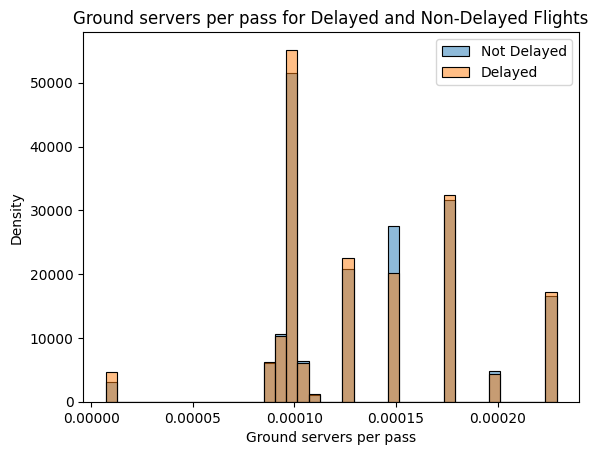

In [ ]:

sns.histplot(data_class0['GROUND_SERV_PER_PASS'], label='Not Delayed', stat="density", bins=40, alpha=0.5)
sns.histplot(data_class1['GROUND_SERV_PER_PASS'], label='Delayed', stat="density", bins=40, alpha=0.5)

plt.title('Ground servers per pass for Delayed and Non-Delayed Flights')
plt.xlabel('Ground servers per pass')
plt.ylabel('Density')
plt.legend()
plt.show()

## AIRLINE_FLIGHTS_MONTH

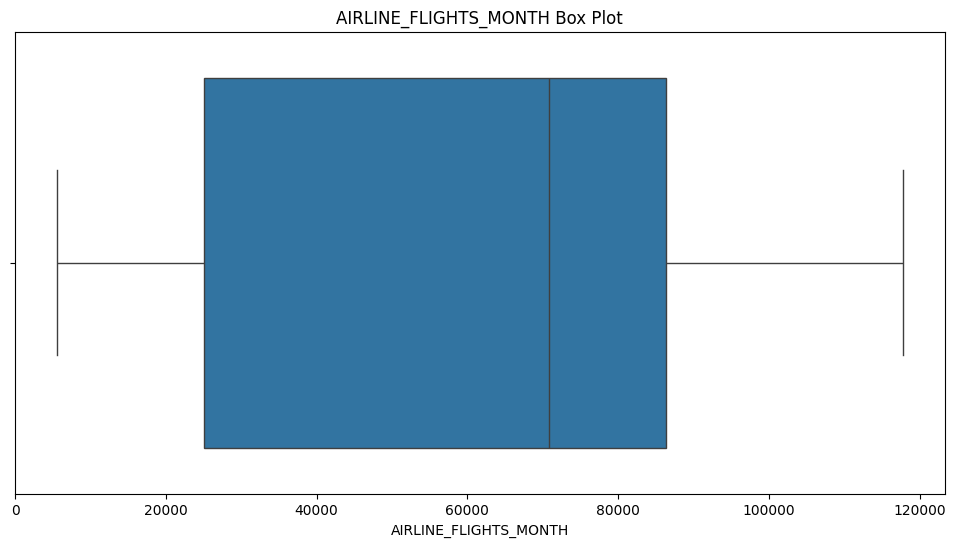

In [ ]:
pandas_df = df.select("AIRLINE_FLIGHTS_MONTH").toPandas()

plt.figure(figsize=(12, 6))
plt.title("AIRLINE_FLIGHTS_MONTH Box Plot")
plt.xlabel("AIRLINE_FLIGHTS_MONTH")

sns.boxplot(data=pandas_df, x="AIRLINE_FLIGHTS_MONTH")

plt.show()

## AIRLINE_AIRPORT_FLIGHTS_MONTH

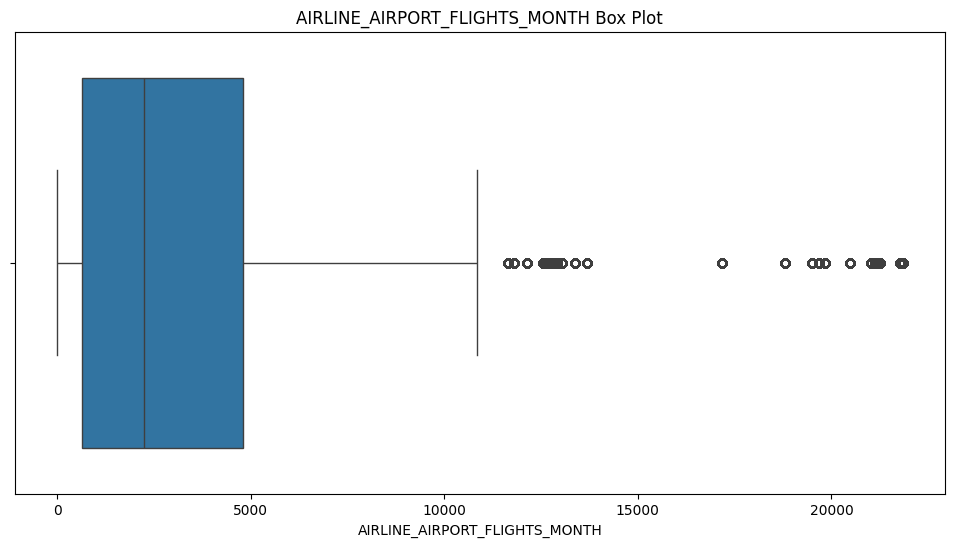

In [ ]:
pandas_df = df.select("AIRLINE_AIRPORT_FLIGHTS_MONTH").toPandas()

plt.figure(figsize=(12, 6))
plt.title("AIRLINE_AIRPORT_FLIGHTS_MONTH Box Plot")
plt.xlabel("AIRLINE_AIRPORT_FLIGHTS_MONTH")

sns.boxplot(data=pandas_df, x="AIRLINE_AIRPORT_FLIGHTS_MONTH")

plt.show()

## CARRIER_NAME

In [ ]:
#df['CARRIER_NAME'].value_counts()
df.groupBy('CARRIER_NAME').count().orderBy('count', ascending=False).show()

+--------------------+-------+
|        CARRIER_NAME|  count|
+--------------------+-------+
|Southwest Airline...|1290872|
|Delta Air Lines Inc.| 935413|
|American Airlines...| 900179|
|United Air Lines ...| 599824|
|SkyWest Airlines ...| 582252|
|Midwest Airline, ...| 298800|
|     JetBlue Airways| 268643|
|Alaska Airlines Inc.| 238345|
|American Eagle Ai...| 228303|
|         Comair Inc.| 219127|
|   Endeavor Air Inc.| 202978|
|    Spirit Air Lines| 188938|
|  Mesa Airlines Inc.| 176864|
|Frontier Airlines...| 120674|
|Atlantic Southeas...|  97637|
|Hawaiian Airlines...|  71256|
|       Allegiant Air|  40484|
+--------------------+-------+



In [ ]:
df_grouped = df.groupBy("CARRIER_NAME") \
    .agg(F.mean("DEP_DEL15").alias("avg_delay_rate"))\
    .orderBy('avg_delay_rate', ascending=False)

In [ ]:
df_grouped_pd = df_grouped.toPandas()
df_grouped.show()

+--------------------+-------------------+
|        CARRIER_NAME|     avg_delay_rate|
+--------------------+-------------------+
|Frontier Airlines...| 0.2610918673450785|
|     JetBlue Airways| 0.2546688355922172|
|Atlantic Southeas...|0.23484949353216505|
|Southwest Airline...|0.21009519146747316|
|American Airlines...| 0.2012666369688695|
|       Allegiant Air|0.19852287323387016|
|United Air Lines ...| 0.1957390834644829|
|  Mesa Airlines Inc.|0.19495770761715217|
|         Comair Inc.|0.19460860596822846|
|    Spirit Air Lines|0.18824693814902244|
|American Eagle Ai...|0.18015531990381203|
|SkyWest Airlines ...| 0.1787112796521094|
|   Endeavor Air Inc.|0.17545743873720304|
|Alaska Airlines Inc.| 0.1652898109882733|
|Midwest Airline, ...|0.16440763052208834|
|Delta Air Lines Inc.| 0.1466795950024214|
|Hawaiian Airlines...|0.09105198158751544|
+--------------------+-------------------+



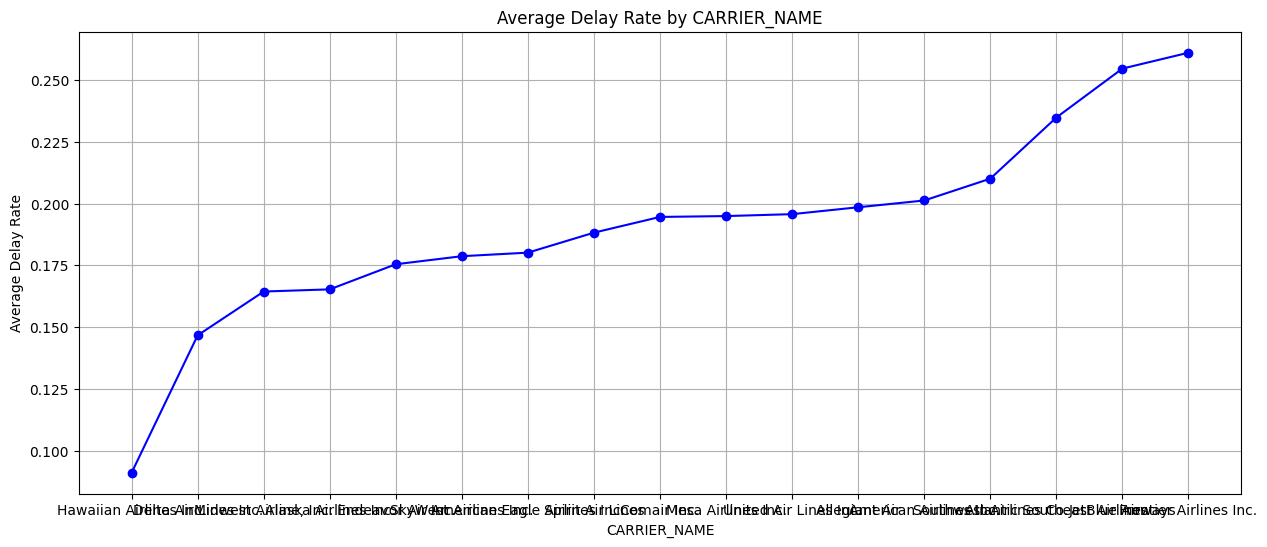

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(df_grouped_pd["CARRIER_NAME"], df_grouped_pd["avg_delay_rate"], marker='o', color='b', linestyle='-')
plt.xlabel("CARRIER_NAME")
plt.ylabel("Average Delay Rate")
plt.title("Average Delay Rate by CARRIER_NAME")
plt.xticks(df_grouped_pd["CARRIER_NAME"])
plt.grid(True)
plt.show()

In [ ]:

df_grouped = df.groupBy("CARRIER_NAME") \
    .agg(F.mean("DEP_DEL15").alias("avg_delay_rate"))\
    .orderBy('avg_delay_rate', ascending=False)

In [ ]:
df.select('AVG_MONTHLY_PASS_AIRLINE').distinct().show()

+------------------------+
|AVG_MONTHLY_PASS_AIRLINE|
+------------------------+
|                 1191889|
|                 2688839|
|                 2884187|
|                 1245396|
|                 3472966|
|                  473794|
|                 1212846|
|                 8501631|
|                 3190369|
|                11744595|
|                 1857122|
|                 1257616|
|                12460183|
|                 1529740|
|                13382999|
|                 1204766|
|                  905990|
+------------------------+



In [ ]:
df.select('CARRIER_NAME', 'AVG_MONTHLY_PASS_AIRLINE').distinct().show()

+--------------------+------------------------+
|        CARRIER_NAME|AVG_MONTHLY_PASS_AIRLINE|
+--------------------+------------------------+
|Midwest Airline, ...|                 1529740|
|Alaska Airlines Inc.|                 2884187|
|Atlantic Southeas...|                  473794|
|Southwest Airline...|                13382999|
|     JetBlue Airways|                 3190369|
|       Allegiant Air|                 1257616|
|Hawaiian Airlines...|                  905990|
|Delta Air Lines Inc.|                12460183|
|Frontier Airlines...|                 1857122|
|  Mesa Airlines Inc.|                 1191889|
|American Eagle Ai...|                 1204766|
|American Airlines...|                11744595|
|SkyWest Airlines ...|                 3472966|
|         Comair Inc.|                 1245396|
|    Spirit Air Lines|                 2688839|
|United Air Lines ...|                 8501631|
|   Endeavor Air Inc.|                 1212846|
+--------------------+------------------

Target encoding CARRIER_NAME

In [ ]:
# Calculate the mean of CARRIER_NAME grouped by DEP_DEL15
mean_encoding = df.groupBy("CARRIER_NAME") \
                   .agg(F.mean("DEP_DEL15").alias("CARRIER_NAME_Encoded"))

df = df.join(mean_encoding, on="CARRIER_NAME", how="left")

In [ ]:
mean_encoding.show(5)

+--------------------+--------------------+
|        CARRIER_NAME|CARRIER_NAME_Encoded|
+--------------------+--------------------+
|   Endeavor Air Inc.| 0.17545743873720304|
|       Allegiant Air| 0.19852287323387016|
|American Eagle Ai...| 0.18015531990381203|
|SkyWest Airlines ...|  0.1787112796521094|
|United Air Lines ...|  0.1957390834644829|
+--------------------+--------------------+
only showing top 5 rows



In [ ]:
df.select('CARRIER_NAME','CARRIER_NAME_Encoded').show()

+--------------------+--------------------+
|        CARRIER_NAME|CARRIER_NAME_Encoded|
+--------------------+--------------------+
|   Endeavor Air Inc.| 0.17545743873720304|
|SkyWest Airlines ...|  0.1787112796521094|
|SkyWest Airlines ...|  0.1787112796521094|
|         Comair Inc.| 0.19460860596822846|
|     JetBlue Airways|  0.2546688355922172|
|     JetBlue Airways|  0.2546688355922172|
|Hawaiian Airlines...| 0.09105198158751544|
|Hawaiian Airlines...| 0.09105198158751544|
|Midwest Airline, ...| 0.16440763052208834|
|Midwest Airline, ...| 0.16440763052208834|
|Midwest Airline, ...| 0.16440763052208834|
|Midwest Airline, ...| 0.16440763052208834|
|Midwest Airline, ...| 0.16440763052208834|
|Delta Air Lines Inc.|  0.1466795950024214|
|Delta Air Lines Inc.|  0.1466795950024214|
|Delta Air Lines Inc.|  0.1466795950024214|
|American Airlines...|  0.2012666369688695|
|American Airlines...|  0.2012666369688695|
|American Airlines...|  0.2012666369688695|
|American Airlines...|  0.201266

## PREVIOUS_AIRPORT

In [ ]:
df.groupBy('PREVIOUS_AIRPORT').count().orderBy('count', ascending=False).show()

+--------------------+-------+
|    PREVIOUS_AIRPORT|  count|
+--------------------+-------+
|                NONE|1423168|
|   Atlanta Municipal| 207275|
|Chicago O'Hare In...| 180372|
|Stapleton Interna...| 138202|
|Dallas Fort Worth...| 134284|
|Los Angeles Inter...| 126914|
|   Douglas Municipal| 123945|
|           LaGuardia| 118657|
| Logan International| 115719|
|Phoenix Sky Harbo...| 108919|
|McCarran Internat...| 108213|
|Detroit Metro Way...| 100049|
|San Francisco Int...| 100001|
|Orlando Internati...|  98308|
|Ronald Reagan Was...|  93806|
|Houston Intercont...|  92466|
|Seattle Internati...|  91208|
|Minneapolis-St Pa...|  91116|
|Newark Liberty In...|  89450|
|John F. Kennedy I...|  82885|
+--------------------+-------+
only showing top 20 rows



Target encoding

In [ ]:
mean_encoding = df.groupBy("PREVIOUS_AIRPORT") \
                   .agg(F.mean("DEP_DEL15").alias("PREVIOUS_AIRPORT_Encoded"))

df = df.join(mean_encoding, on="PREVIOUS_AIRPORT", how="left")

In [ ]:
mean_encoding.show(5)

+--------------------+------------------------+
|    PREVIOUS_AIRPORT|PREVIOUS_AIRPORT_Encoded|
+--------------------+------------------------+
|Kalamazoo/Battle ...|     0.16402378592666006|
|Stewart Internati...|                  0.2704|
|     Muskegon County|     0.19306184012066366|
|     Eppley Airfield|     0.20879218079695724|
|  Lafayette Regional|      0.1763540290620872|
+--------------------+------------------------+
only showing top 5 rows



In [ ]:
df.select('PREVIOUS_AIRPORT','PREVIOUS_AIRPORT_Encoded').show()

+--------------------+------------------------+
|    PREVIOUS_AIRPORT|PREVIOUS_AIRPORT_Encoded|
+--------------------+------------------------+
|Chicago O'Hare In...|     0.24030891712682678|
|                NONE|     0.12372116292665378|
|                NONE|     0.12372116292665378|
|                NONE|     0.12372116292665378|
|                NONE|     0.12372116292665378|
|                NONE|     0.12372116292665378|
|                NONE|     0.12372116292665378|
|                NONE|     0.12372116292665378|
|                NONE|     0.12372116292665378|
|                NONE|     0.12372116292665378|
|                NONE|     0.12372116292665378|
|                NONE|     0.12372116292665378|
|                NONE|     0.12372116292665378|
|                NONE|     0.12372116292665378|
|                NONE|     0.12372116292665378|
|                NONE|     0.12372116292665378|
|                NONE|     0.12372116292665378|
|                NONE|     0.12372116292

## DEPARTING_AIRPORT

In [ ]:
df.groupBy('DEPARTING_AIRPORT').count().orderBy('count', ascending=False).show()

+--------------------+------+
|   DEPARTING_AIRPORT| count|
+--------------------+------+
|   Atlanta Municipal|391196|
|Chicago O'Hare In...|327971|
|Dallas Fort Worth...|295232|
|Stapleton Interna...|246365|
|   Douglas Municipal|231346|
|Los Angeles Inter...|216378|
|Houston Intercont...|175468|
|Phoenix Sky Harbo...|172312|
|San Francisco Int...|166823|
|           LaGuardia|165699|
|McCarran Internat...|160210|
|Detroit Metro Way...|159449|
|Minneapolis-St Pa...|159039|
| Logan International|146838|
|Seattle Internati...|141163|
|Orlando Internati...|140260|
|Ronald Reagan Was...|135611|
|Newark Liberty In...|131970|
|John F. Kennedy I...|124522|
|Philadelphia Inte...|116549|
+--------------------+------+
only showing top 20 rows



Target encoding

In [ ]:
mean_encoding = df.groupBy("DEPARTING_AIRPORT") \
                   .agg(F.mean("DEP_DEL15").alias("DEPARTING_AIRPORT_Encoded"))

df = df.join(mean_encoding, on="DEPARTING_AIRPORT", how="left")

In [ ]:
mean_encoding.show(5)

+--------------------+-------------------------+
|   DEPARTING_AIRPORT|DEPARTING_AIRPORT_Encoded|
+--------------------+-------------------------+
|     Eppley Airfield|      0.16108622180303386|
|     Kahului Airport|       0.1096187661341614|
|Greater Buffalo I...|      0.16608695652173913|
|Sacramento Intern...|      0.14860471146749646|
|Chicago O'Hare In...|      0.22558092026429166|
+--------------------+-------------------------+
only showing top 5 rows



In [ ]:
df.select('DEPARTING_AIRPORT','DEPARTING_AIRPORT_Encoded').show()

+--------------------+-------------------------+
|   DEPARTING_AIRPORT|DEPARTING_AIRPORT_Encoded|
+--------------------+-------------------------+
|   Will Rogers World|       0.1685573992549949|
|   Will Rogers World|       0.1685573992549949|
|San Antonio Inter...|       0.1535024214888412|
|Savannah/Hilton H...|       0.1804283238425353|
|Honolulu Internat...|      0.10682341435586072|
|Honolulu Internat...|      0.10682341435586072|
|Newark Liberty In...|       0.2553383344699553|
| Logan International|      0.21379343221781827|
|Piedmont Triad In...|      0.16846258916375778|
|Piedmont Triad In...|      0.16846258916375778|
|Piedmont Triad In...|      0.16846258916375778|
|General Mitchell ...|       0.1599138645022362|
|Washington Dulles...|      0.15818925423378463|
|Houston Intercont...|      0.19337998951375748|
|McCarran Internat...|       0.2014106485238125|
|Charleston Intern...|      0.16452268111035884|
|Charleston Intern...|      0.16452268111035884|
|Charleston Intern..

# Scaling

Naive Bayes does not require scaling

Saving processed file

In [ ]:
df.write \
    .option("header", "true") \
    .csv("AirlineProcessed", mode='overwrite')

Saved 7 files, need to use coalesce(1) to reduce to one partition

In [ ]:
# setting up columns to be used for training the models
cols = ['DEP_DEL15',
'DISTANCE_GROUP',
'SEGMENT_NUMBER',
'CONCURRENT_FLIGHTS',
'CARRIER_NAME_Encoded',
'AIRPORT_FLIGHTS_MONTH',
'AIRLINE_AIRPORT_FLIGHTS_MONTH',
'PLANE_AGE',
'DEPARTING_AIRPORT_Encoded',
'PREVIOUS_AIRPORT_Encoded',
'PRCP',
'AWND',
'SNOW',
'SNWD']

colss = ['DISTANCE_GROUP',
'SEGMENT_NUMBER',
'CONCURRENT_FLIGHTS',
'CARRIER_NAME_Encoded',
'AIRPORT_FLIGHTS_MONTH',
'AIRLINE_AIRPORT_FLIGHTS_MONTH',
'PLANE_AGE',
'DEPARTING_AIRPORT_Encoded',
'PREVIOUS_AIRPORT_Encoded',
'PRCP',
'AWND',
'SNOW',
'SNWD']


# Naive Bayes

## Using Pandas and Sklearn

In [ ]:
df = pd.read_csv("/path/to/AirlinePreProcessed.csv")

In [ ]:
df1 =df[cols]
X = df1.drop(columns=['DEP_DEL15'])
y = df1['DEP_DEL15']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = GaussianNB()

In [ ]:
start_time = time.time()

model.fit(X_train, y_train)

end_time = time.time()
time_taken = end_time - start_time
print(f"Time taken to train the model: {round(time_taken,2)} seconds")

Time taken to train the model: 6.23 seconds


In [ ]:
y_pred = model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.80
Confusion Matrix:
[[1019551   27143]
 [ 232317   13107]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.97      0.89   1046694
           1       0.33      0.05      0.09    245424

    accuracy                           0.80   1292118
   macro avg       0.57      0.51      0.49   1292118
weighted avg       0.72      0.80      0.74   1292118



## Using pyspark

In [ ]:
df = spark.read.csv("/path/to/AirlinePreProcessed.csv", header=True, inferSchema=True)

In [ ]:
df.show()

+-----------------+-----------------+--------------------+-----+-----------+---------+------------+--------------+--------------+------------------+---------------+---------------------+---------------------+-----------------------------+------------------------+------------------------+-----------------------+--------------------+---------+--------+---------+----+----+----+----+-----+---------------------------+-------------------------+-----------+-----------+-----------+-----------+--------------+------------------------+-------------------------+--------------------+
|     CARRIER_NAME|DEPARTING_AIRPORT|    PREVIOUS_AIRPORT|MONTH|DAY_OF_WEEK|DEP_DEL15|DEP_TIME_BLK|DISTANCE_GROUP|SEGMENT_NUMBER|CONCURRENT_FLIGHTS|NUMBER_OF_SEATS|AIRPORT_FLIGHTS_MONTH|AIRLINE_FLIGHTS_MONTH|AIRLINE_AIRPORT_FLIGHTS_MONTH|AVG_MONTHLY_PASS_AIRPORT|AVG_MONTHLY_PASS_AIRLINE|FLT_ATTENDANTS_PER_PASS|GROUND_SERV_PER_PASS|PLANE_AGE|LATITUDE|LONGITUDE|PRCP|SNOW|SNWD|TMAX| AWND|carrier_flights_interaction|log_ai

In [ ]:
featureassembler= VectorAssembler(inputCols=colss, outputCol='Features')
output = featureassembler.transform(df)

In [ ]:
modeldata=output.select('Features','DEP_DEL15')

In [ ]:
train_data,test_data=modeldata.randomSplit([0.8,0.2],seed = 123)
train_data.show()

+--------------------+---------+
|            Features|DEP_DEL15|
+--------------------+---------+
|[1.0,1.0,1.0,0.14...|        0|
|[1.0,1.0,1.0,0.14...|        0|
|[1.0,1.0,1.0,0.14...|        0|
|[1.0,1.0,1.0,0.14...|        0|
|[1.0,1.0,1.0,0.14...|        0|
|[1.0,1.0,1.0,0.14...|        0|
|[1.0,1.0,1.0,0.14...|        0|
|[1.0,1.0,1.0,0.14...|        0|
|[1.0,1.0,1.0,0.14...|        0|
|[1.0,1.0,1.0,0.14...|        0|
|[1.0,1.0,1.0,0.17...|        0|
|[1.0,1.0,1.0,0.17...|        0|
|[1.0,1.0,1.0,0.17...|        1|
|[1.0,1.0,1.0,0.17...|        0|
|[1.0,1.0,1.0,0.17...|        0|
|[1.0,1.0,1.0,0.17...|        0|
|[1.0,1.0,1.0,0.17...|        0|
|[1.0,1.0,1.0,0.17...|        1|
|[1.0,1.0,1.0,0.19...|        0|
|[1.0,1.0,1.0,0.19...|        0|
+--------------------+---------+
only showing top 20 rows



In [ ]:
from pyspark.ml.classification import NaiveBayes

# Initialize NaiveBayes model
nb = NaiveBayes(featuresCol="Features", labelCol="DEP_DEL15", modelType="gaussian")

start_time = time.time()
model = nb.fit(train_data)
end_time = time.time()

time_taken = end_time - start_time
print(f"Time taken to train the model: {round(time_taken,2)} seconds")

Time taken to train the model: 161.07 seconds


In [ ]:
# prediction
y_pred = model.transform(test_data)
# confusion matrix
y_pred.groupBy('DEP_DEL15', 'prediction').count().show()

+---------+----------+-------+
|DEP_DEL15|prediction|  count|
+---------+----------+-------+
|        1|       0.0| 232432|
|        0|       0.0|1019829|
|        1|       1.0|  13111|
|        0|       1.0|  27078|
+---------+----------+-------+



In [ ]:
# evaluation
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(
    labelCol="DEP_DEL15",
    rawPredictionCol="rawPrediction"
)
accuracy = evaluator.evaluate(y_pred)
accuracy


0.7360246707141473

In [ ]:
pred_labels = y_pred.select("probability", "DEP_DEL15").collect()
y_score = [row[0][1] for row in pred_labels]
y_true = [row[1] for row in pred_labels]


In [ ]:
# Convert probabilities (y_score) into binary predictions (y_pred)
from sklearn.metrics import classification_report
y_pred = [1 if score >= 0.5 else 0 for score in y_score]

# Generate the classification report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.97      0.89   1046907
           1       0.33      0.05      0.09    245543

    accuracy                           0.80   1292450
   macro avg       0.57      0.51      0.49   1292450
weighted avg       0.72      0.80      0.74   1292450



## Pandas and Sklearn

In [ ]:
pddf1=df[df['DEP_DEL15']==1].sample(n =1000000, random_state =152)
pddf0=df[df['DEP_DEL15']==0].sample(n =1000000, random_state = 153)

In [ ]:
pddf = pd.concat([pddf1,pddf0], axis= 0)

In [ ]:

pddf = pddf.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
#df = pd.read_csv("AirlineProcessed.csv")
df3 =pddf[cols]
Xi = df3.drop(columns=['DEP_DEL15'])
yi = df3['DEP_DEL15']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Xi, yi, test_size=0.2, random_state=42)

model = GaussianNB()

In [ ]:

start_time = time.time()

model.fit(X_train, y_train)

end_time = time.time()
time_taken = end_time - start_time
print(f"Time taken to train the model: {round(time_taken,2)} seconds")

Time taken to train the model: 1.76 seconds


In [ ]:
y_pred = model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.53
Confusion Matrix:
[[185091  15095]
 [171462  28352]]
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.92      0.66    200186
           1       0.65      0.14      0.23    199814

    accuracy                           0.53    400000
   macro avg       0.59      0.53      0.45    400000
weighted avg       0.59      0.53      0.45    400000



## Pyspark

In [ ]:
from pyspark.sql.functions import col
num_samples = 1000000

# Sample exactly 1 million from class 0
data_0 = modeldata.filter(col("DEP_DEL15") == 0).sample(False, num_samples / modeldata.filter(col("DEP_DEL15") == 0).count(), seed=123)

In [ ]:
# Sample exactly 1 million from class 1
data_1 = modeldata.filter(col("DEP_DEL15") == 1).sample(False, num_samples / modeldata.filter(col("DEP_DEL15") == 1).count(), seed=123)

data = data_0.union(data_1)

In [ ]:
featureassembler= VectorAssembler(inputCols=colss, outputCol='Features')
output = featureassembler.transform(df)

In [ ]:
modeldata=output.select('Features','DEP_DEL15')

In [ ]:
train_data,test_data=data.randomSplit([0.8,0.2],seed = 123)
train_data.show()

+--------------------+---------+
|            Features|DEP_DEL15|
+--------------------+---------+
|[1.0,1.0,1.0,0.14...|        0|
|[1.0,1.0,1.0,0.14...|        0|
|[1.0,1.0,2.0,0.09...|        0|
|[1.0,1.0,2.0,0.14...|        0|
|[1.0,1.0,2.0,0.14...|        0|
|[1.0,1.0,2.0,0.14...|        0|
|[1.0,1.0,2.0,0.14...|        0|
|[1.0,1.0,2.0,0.14...|        0|
|[1.0,1.0,2.0,0.14...|        0|
|[1.0,1.0,2.0,0.14...|        0|
|[1.0,1.0,2.0,0.14...|        0|
|[1.0,1.0,2.0,0.14...|        0|
|[1.0,1.0,2.0,0.14...|        0|
|[1.0,1.0,2.0,0.14...|        0|
|[1.0,1.0,2.0,0.14...|        0|
|[1.0,1.0,2.0,0.14...|        0|
|[1.0,1.0,2.0,0.14...|        0|
|[1.0,1.0,2.0,0.17...|        0|
|[1.0,1.0,2.0,0.17...|        0|
|[1.0,1.0,2.0,0.17...|        0|
+--------------------+---------+
only showing top 20 rows



In [ ]:
from pyspark.ml.classification import NaiveBayes


nb = NaiveBayes(featuresCol="Features", labelCol="DEP_DEL15", modelType="multinomial")

start_time = time.time()
model = nb.fit(train_data)
end_time = time.time()

time_taken = end_time - start_time
print(f"Time taken to train the model: {round(time_taken,2)} seconds")

Time taken to train the model: 193.43 seconds


In [ ]:
# prediction
y_pred = model.transform(test_data)
# confusion matrix
y_pred.groupBy('DEP_DEL15', 'prediction').count().show()

+---------+----------+------+
|DEP_DEL15|prediction| count|
+---------+----------+------+
|        0|       0.0| 78810|
|        0|       1.0|120736|
|        1|       0.0| 79967|
|        1|       1.0|120147|
+---------+----------+------+



In [ ]:
# evaluation
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(
    labelCol="DEP_DEL15",
    rawPredictionCol="rawPrediction"
)

accuracy = evaluator.evaluate(y_pred)
accuracy

0.471114889174652

In [ ]:
pred_labels = y_pred.select("probability", "DEP_DEL15").collect()
y_score = [row[0][1] for row in pred_labels]
y_true = [row[1] for row in pred_labels]


In [ ]:
# Convert probabilities (y_score) into binary predictions (y_pred)
from sklearn.metrics import classification_report
y_pred = [1 if score >= 0.5 else 0 for score in y_score]

# Generate the classification report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.39      0.44    199546
           1       0.50      0.60      0.54    200114

    accuracy                           0.50    399660
   macro avg       0.50      0.50      0.49    399660
weighted avg       0.50      0.50      0.49    399660



#Hyper parameter

###Accuracy

In [ ]:
# Initialize NaiveBayes model
nb = NaiveBayes(featuresCol="Features", labelCol="DEP_DEL15")

In [ ]:
paramGrid = ParamGridBuilder() \
    .addGrid(nb.smoothing, [0.5, 1.0, 2.0]) \
    .addGrid(nb.modelType, ['gaussian','multinomial']) \
    .build()

evaluator = MulticlassClassificationEvaluator(labelCol="DEP_DEL15", predictionCol="prediction", metricName="accuracy")

crossval = CrossValidator(estimator=nb,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)  # 3-fold cross-validation

cvModel = crossval.fit(train_data)


In [ ]:
bestModel = cvModel.bestModel
print("Best Smoothing Parameter: ", bestModel._java_obj.getSmoothing())
print("Best Model Type: ", bestModel._java_obj.getModelType())

Best Smoothing Parameter:  0.5
Best Model Type:  multinomial


In [ ]:
predictions = bestModel.transform(test_data)
accuracy = evaluator.evaluate(predictions)
print("Test Accuracy: ", accuracy)

Test Accuracy:  0.8044223185845363


In [ ]:
pred_labels = predictions.select("probability", "DEP_DEL15").collect()
y_score = [row[0][1] for row in pred_labels]
y_true = [row[1] for row in pred_labels]

In [ ]:
# Convert probabilities (y_score) into binary predictions (y_pred)
from sklearn.metrics import classification_report
y_pred = [1 if score >= 0.5 else 0 for score in y_score]

# Generate the classification report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.98      0.89   1047619
           1       0.34      0.03      0.06    245187

    accuracy                           0.80   1292806
   macro avg       0.58      0.51      0.48   1292806
weighted avg       0.72      0.80      0.73   1292806



###Recall

In [ ]:
paramGrid = ParamGridBuilder() \
    .addGrid(nb.smoothing, [0.5, 1.0, 2.0]) \
    .addGrid(nb.modelType, ['gaussian','multinomial']) \
    .build()


evaluator = MulticlassClassificationEvaluator(
    labelCol="DEP_DEL15",
    predictionCol="prediction",
    metricName="recallByLabel"
)

evaluator.setMetricLabel(1)

crossval = CrossValidator(estimator=nb,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

cvModel = crossval.fit(train_data)


In [ ]:
bestModel = cvModel.bestModel
print("Best Smoothing Parameter: ", bestModel._java_obj.getSmoothing())
print("Best Model Type: ", bestModel._java_obj.getModelType())

Best Smoothing Parameter:  0.5
Best Model Type:  multinomial


In [ ]:
predictions = bestModel.transform(test_data)
recall = evaluator.evaluate(predictions)
print(f"Recall for class 1: {recall}")

Recall for class 1: 0.600392776117613


In [ ]:
pred_labels = predictions.select("probability", "DEP_DEL15").collect()
y_score = [row[0][1] for row in pred_labels]
y_true = [row[1] for row in pred_labels]

In [ ]:
# Convert probabilities (y_score) into binary predictions (y_pred)
from sklearn.metrics import classification_report
y_pred = [1 if score >= 0.5 else 0 for score in y_score]

# Generate the classification report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.39      0.44    199546
           1       0.50      0.60      0.54    200114

    accuracy                           0.50    399660
   macro avg       0.50      0.50      0.49    399660
weighted avg       0.50      0.50      0.49    399660

